In [47]:
from __future__ import division, print_function, absolute_import

import cv2
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

import shapely.geometry as geom
import geopandas as gpd

from latlon_to_pixelXY import lonlatToPixel, get_image_corner_latlon_and_pxls_vals
import utils as utl

zoom = 19
lat, lon = 41.845989, -87.717689
static_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/staticmap0.png'
output_manual_segment = '/Users/sam/All-Program/App-DataSet/HouseClassification/staticmap0_out.png'

# zoom = 19
# lat, lon = 41.845824,-87.716752
# static_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/staticmap1.png'
# output_manual_segment = '/Users/sam/All-Program/App-DataSet/HouseClassification/staticmap1_out.png'


property_parcel_shape_file_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/shape_files/sample/'

%matplotlib inline

## Get static image corners in terms of Lat and Lon
---------

In [48]:
pxls_corner_arr, lonlat_corner_arr = get_image_corner_latlon_and_pxls_vals(lat, lon, zoom)
tl_ll, tr_ll, bl_ll, br_ll = lonlat_corner_arr
tl_pxl, tr_pxl, bl_pxl, br_pxl = pxls_corner_arr
image_corner_polygon = geom.Polygon(np.array([tl_ll, tr_ll, br_ll, bl_ll, tl_ll]))   # The polygon should start from a point and end at the same point
print (image_corner_polygon)

POLYGON ((-87.71822544180296 41.84638861611691, -87.717152558197 41.84638861611691, -87.717152558197 41.84558938138701, -87.71822544180296 41.84558938138701, -87.71822544180296 41.84638861611691))


In [49]:
# Check if the center of the Polygon is the same as the provided Lat Lon
np.array(image_corner_polygon.centroid.coords)[0]

array([-87.717689,  41.845989])

## Fetch all the parcels that lie inside the Image extracted
--------

#### Step1: Get the Scooped lat lon list

In [50]:
## Get the extra scoop's: We dont want to search for all the property, but the property that are neat the vicinity of the extracted image
scoop_lon, scooop_lat = utl.getscoopLonLat(lonIN=lon, latIN=lat, decimalPlaces=1000)
scoop_latlon = utl.getscoopSearchItems(scoopLon=scoop_lon, scoopLat=scooop_lat, decimalPlaces=1000)
print (scoop_latlon)

[['-87.718' '41.844']
 ['-87.718' '41.845']
 ['-87.718' '41.846']
 ['-87.717' '41.844']
 ['-87.717' '41.845']
 ['-87.717' '41.846']
 ['-87.716' '41.844']
 ['-87.716' '41.845']
 ['-87.716' '41.846']]


#### Step2: Get all the property in the scoop

In [51]:
def get_search_polygons(df, scoop_latlon):
    query = ''
    for num, (i, j) in enumerate(scoop_latlon):
        query += '((lon_scoop=="%s") & (lat_scoop=="%s"))'%(str(i),(j))
        if num!=(len(scoop_latlon)-1):
            query += ' | '
    return df[df.eval(query)]
#     query = 'building==%s'%('"yes"')
#     break
property_parcel = gpd.read_file(property_parcel_shape_file_path)
search_polygons = get_search_polygons(property_parcel, scoop_latlon)
print (search_polygons.shape)
search_polygons.head()

(78, 13)


,parcel_id,house_numb,street_add,street_nam,street_pre,building,building_l,shape_type,lat_scoop,lon_scoop,lat_center,lon_center,geometry
0,way/163767492,2451,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84650960512757,-87.71703814927186,"POLYGON ((-87.7171232 41.8464752, -87.71712309..."
2,way/163767501,2452,South Lawndale Avenue,Lawndale,South,yes,3,Polygon,41.846,-87.717,41.84648109184263,-87.71759474590094,"POLYGON ((-87.7175713 41.8464392, -87.7175877 ..."
3,way/163767522,2454,South Millard Avenue,Millard,South,yes,2,Polygon,41.846,-87.716,41.8464311907146,-87.71636055067256,"POLYGON ((-87.71636599999999 41.846397, -87.71..."
4,way/163767530,2455,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84642069292985,-87.71702471950471,"POLYGON ((-87.71712220000001 41.8463833, -87.7..."
5,way/163767543,2456,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84636960337455,-87.71757841554287,"POLYGON ((-87.7174859 41.846344, -87.7176695 4..."


#### Out of the scooped Properties, Select only the properties that have the center point inside the image polygon

In [52]:
def get_parcels_inside_image(df):
    list_parcel_ids = []
    for parcel_id, lon_cent, lat_cent in np.array(df[['parcel_id','lon_center', 'lat_center']]):
        lon_cent = float(lon_cent) 
        lat_cent = float(lat_cent)
        is_contains = image_corner_polygon.contains(geom.Point([lon_cent, lat_cent]))
        if is_contains:
#             print (parcel_id)
            list_parcel_ids.append(parcel_id)
            
    if len(list_parcel_ids) > 0:
        return df[df['parcel_id'].isin(list_parcel_ids)]
    
parcels_in_image = get_parcels_inside_image(search_polygons)
print (parcels_in_image.shape)
parcels_in_image.head()

(8, 13)


,parcel_id,house_numb,street_add,street_nam,street_pre,building,building_l,shape_type,lat_scoop,lon_scoop,lat_center,lon_center,geometry
5,way/163767543,2456,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84636960337455,-87.71757841554287,"POLYGON ((-87.7174859 41.846344, -87.7176695 4..."
6,way/163767553,2458,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84631333683656,-87.71757668909439,"POLYGON ((-87.7174859 41.846344, -87.7174828 4..."
9,way/163767576,2500,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.8460560082056,-87.71756770040085,"POLYGON ((-87.71754610000001 41.8459958, -87.7..."
14,way/163767641,2506,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.845,-87.717,41.84593256973168,-87.71756505789992,"POLYGON ((-87.71766820000001 41.8459018, -87.7..."
16,way/163767657,2508,South Lawndale Avenue,Lawndale,South,yes,1,Polygon,41.845,-87.717,41.845863773618,-87.71754821084377,"POLYGON ((-87.7176102 41.845826, -87.7176303 4..."


In [53]:
# print (bl_pxl)
# for pid, geomt in np.array(parcels_in_image[['parcel_id', 'geometry']]):
#     print (pid)
#     arr = geomt.exterior.coords.xy
#     llon, llat = arr[0], arr[1]
#     arr_in = [(i, j) for i, j in zip(llat, llon)]
    
#     for latt, lonn in arr_in:
#         mx, my = obj_ll_to_pxl.lonlat_to_meters(lonn,latt)
#         px, py = obj_ll_to_pxl.meters_to_pixels(mx, my)
#         print (px, py)
#         img_x, img_y = obj_ll_to_pxl.convert_map_pxl_to_img_pxl(bl_pxl, [px, py])
#         print (img_x, img_y)
#     print ('')

## PLOT the parcel boundaries on top of the image
-------------

#### Convert parcel Lat Lon to pixel places in Image

In [54]:
img_orig = cv2.imread(static_image_path)

img = img_orig.copy()
# output = img_orig.copy()

# def draw_polygons(img, xy_arr):
#     alpha = 0.5
#     xy_arr = np.array(xy_arr, np.int32)
# #     xy_arr = xy_arr.reshape(-1,1,2) 
#     img = cv2.polylines(img,[xy_arr],True,(0,0,255))
#     img = cv2.addWeighted(img, alpha, output, 1 - alpha, 0, output)
#     return output

def draw_polygons(img, xy_arr):
    alpha = 0.5
    xy_arr = np.array(xy_arr, np.int32)
    layer = img.copy()
    output = img.copy()
    layer = cv2.fillPoly(layer, [xy_arr], (0,0,255))#, offset=0.4)
    output = cv2.addWeighted(layer, alpha, output, 1 - alpha, 0, output)
    return output

a = []
obj_ll_to_pxl = lonlatToPixel(zoom=19)
parcel_pixel_vals = []
for parcel_id, polygon_geom in np.array(parcels_in_image[['parcel_id', 'geometry']]):
    points_tuple = polygon_geom.exterior.coords.xy
    lon_arr, lat_arr = list(points_tuple[0]), list(points_tuple[1])
    each_parcel_xy_arr = []
    for lon, lat in zip(lon_arr, lat_arr):
        mx, my = obj_ll_to_pxl.lonlat_to_meters(lon,lat)
        px, py = obj_ll_to_pxl.meters_to_pixels(mx, my)
#         print (tl_pxl)
#         print (px, py)
        img_x, img_y = obj_ll_to_pxl.convert_map_pxl_to_img_pxl(tl_pxl, [px, py])
        each_parcel_xy_arr.append([int(np.round(img_x)), int(np.round(img_y))])
    img = draw_polygons(img, xy_arr=each_parcel_xy_arr)


The new pixel value is not bounded by the images shape 
The new pixel value is not bounded by the images shape 
The new pixel value is not bounded by the images shape 
The new pixel value is not bounded by the images shape 
The new pixel value is not bounded by the images shape 


In [55]:
cv2.imwrite(output_manual_segment, img)

True

# ROUGH:
-------------

In [46]:
property_parcel[((property_parcel['lon_scoop']=='-87.717') & (property_parcel['lat_scoop']=='41.846')) | 
                ((property_parcel['lon_scoop']=='-87.716') & (property_parcel['lat_scoop']=='41.846'))]  # 41.846	-87.717

,parcel_id,house_numb,street_add,street_nam,street_pre,building,building_l,shape_type,lat_scoop,lon_scoop,lat_center,lon_center,geometry
0,way/163767492,2451,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84650960512757,-87.71703814927186,"POLYGON ((-87.7171232 41.8464752, -87.71712309..."
2,way/163767501,2452,South Lawndale Avenue,Lawndale,South,yes,3,Polygon,41.846,-87.717,41.84648109184263,-87.71759474590094,"POLYGON ((-87.7175713 41.8464392, -87.7175877 ..."
3,way/163767522,2454,South Millard Avenue,Millard,South,yes,2,Polygon,41.846,-87.716,41.8464311907146,-87.71636055067256,"POLYGON ((-87.71636599999999 41.846397, -87.71..."
4,way/163767530,2455,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84642069292985,-87.71702471950471,"POLYGON ((-87.71712220000001 41.8463833, -87.7..."
5,way/163767543,2456,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84636960337455,-87.71757841554287,"POLYGON ((-87.7174859 41.846344, -87.7176695 4..."
6,way/163767553,2458,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84631333683656,-87.71757668909439,"POLYGON ((-87.7174859 41.846344, -87.7174828 4..."
7,way/163767565,2459,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.716,41.84632306647141,-87.71699989606041,"POLYGON ((-87.7171195 41.8462831, -87.7171304 ..."
9,way/163767576,2500,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.8460560082056,-87.71756770040085,"POLYGON ((-87.71754610000001 41.8459958, -87.7..."
10,way/163767578,2500,South Millard Avenue,Millard,South,yes,3,Polygon,41.846,-87.716,41.8460737203175,-87.71641003797632,"POLYGON ((-87.7166117 41.8460361, -87.7166129 ..."
67,way/163769422,3651-3655,West 25th Street,25th,West,yes,3,Polygon,41.846,-87.716,41.84606098862837,-87.71692200184826,"POLYGON ((-87.7171037 41.8460168, -87.71710659..."


(78, 13)


,parcel_id,house_numb,street_add,street_nam,street_pre,building,building_l,shape_type,lat_scoop,lon_scoop,lat_center,lon_center,geometry
0,way/163767492,2451,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84650960512757,-87.71703814927186,"POLYGON ((-87.7171232 41.8464752, -87.71712309..."
2,way/163767501,2452,South Lawndale Avenue,Lawndale,South,yes,3,Polygon,41.846,-87.717,41.84648109184263,-87.71759474590094,"POLYGON ((-87.7175713 41.8464392, -87.7175877 ..."
3,way/163767522,2454,South Millard Avenue,Millard,South,yes,2,Polygon,41.846,-87.716,41.8464311907146,-87.71636055067256,"POLYGON ((-87.71636599999999 41.846397, -87.71..."
4,way/163767530,2455,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84642069292985,-87.71702471950471,"POLYGON ((-87.71712220000001 41.8463833, -87.7..."
5,way/163767543,2456,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84636960337455,-87.71757841554287,"POLYGON ((-87.7174859 41.846344, -87.7176695 4..."


In [51]:
property_parcel[property_parcel.eval(query)]

,parcel_id,house_numb,street_add,street_nam,street_pre,building,building_l,shape_type,lat_scoop,lon_scoop,lat_center,lon_center,geometry
0,way/163767492,2451,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84650960512757,-87.71703814927186,"POLYGON ((-87.7171232 41.8464752, -87.71712309..."
2,way/163767501,2452,South Lawndale Avenue,Lawndale,South,yes,3,Polygon,41.846,-87.717,41.84648109184263,-87.71759474590094,"POLYGON ((-87.7175713 41.8464392, -87.7175877 ..."
3,way/163767522,2454,South Millard Avenue,Millard,South,yes,2,Polygon,41.846,-87.716,41.8464311907146,-87.71636055067256,"POLYGON ((-87.71636599999999 41.846397, -87.71..."
4,way/163767530,2455,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84642069292985,-87.71702471950471,"POLYGON ((-87.71712220000001 41.8463833, -87.7..."
5,way/163767543,2456,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84636960337455,-87.71757841554287,"POLYGON ((-87.7174859 41.846344, -87.7176695 4..."
6,way/163767553,2458,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84631333683656,-87.71757668909439,"POLYGON ((-87.7174859 41.846344, -87.7174828 4..."
7,way/163767565,2459,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.716,41.84632306647141,-87.71699989606041,"POLYGON ((-87.7171195 41.8462831, -87.7171304 ..."
9,way/163767576,2500,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.8460560082056,-87.71756770040085,"POLYGON ((-87.71754610000001 41.8459958, -87.7..."
10,way/163767578,2500,South Millard Avenue,Millard,South,yes,3,Polygon,41.846,-87.716,41.8460737203175,-87.71641003797632,"POLYGON ((-87.7166117 41.8460361, -87.7166129 ..."
12,way/163767613,2504,South Millard Avenue,Millard,South,yes,1,Polygon,41.845,-87.716,41.84598110265578,-87.71634480887434,"POLYGON ((-87.7164217 41.8459445, -87.7164216 ..."


In [8]:
property_parcel = gpd.read_file(property_parcel_shape_file_path)
print (property_parcel.shape)
property_parcel.head()

(93, 13)


,parcel_id,house_numb,street_add,street_nam,street_pre,building,building_l,shape_type,lat_scoop,lon_scoop,lat_center,lon_center,geometry
0,way/163767492,2451,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84650960512757,-87.71703814927186,"POLYGON ((-87.7171232 41.8464752, -87.71712309..."
1,way/163767493,2451,South Millard Avenue,Millard,South,yes,2,Polygon,41.846,-87.715,41.84652377513783,-87.71582629867582,"POLYGON ((-87.7159137 41.8464865, -87.71591549..."
2,way/163767501,2452,South Lawndale Avenue,Lawndale,South,yes,3,Polygon,41.846,-87.717,41.84648109184263,-87.71759474590094,"POLYGON ((-87.7175713 41.8464392, -87.7175877 ..."
3,way/163767522,2454,South Millard Avenue,Millard,South,yes,2,Polygon,41.846,-87.716,41.8464311907146,-87.71636055067256,"POLYGON ((-87.71636599999999 41.846397, -87.71..."
4,way/163767530,2455,South Lawndale Avenue,Lawndale,South,yes,2,Polygon,41.846,-87.717,41.84642069292985,-87.71702471950471,"POLYGON ((-87.71712220000001 41.8463833, -87.7..."


In [7]:
csvData.loc[0,'geometry'].area

1.2003820000129982e-08

In [8]:
county_data = gpd.read_file(county_data_path)
print (county_data.shape)
county_data.head()

(3233, 10)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,19,107,00465242,0500000US19107,19107,Keokuk,06,1500067253,1929323,"POLYGON ((-92.41199499999999 41.509548, -92.35..."
1,19,189,00465283,0500000US19189,19189,Winnebago,06,1037261946,3182052,"POLYGON ((-93.97076 43.499605, -93.88843009910..."
2,20,093,00485011,0500000US20093,20093,Kearny,06,2254696689,1133601,"POLYGON ((-101.54192 37.914575, -101.541863 37..."
3,20,123,00485026,0500000US20123,20123,Mitchell,06,1817632928,44979981,"POLYGON ((-98.49006799999999 39.241666, -98.49..."
4,20,187,00485055,0500000US20187,20187,Stanton,06,1762104518,178555,"POLYGON ((-102.041899 37.541186, -102.041894 3..."


In [9]:
county_data['NAME'] = county_data['NAME'].str.lower()
cook_county = county_data[(county_data['NAME'] == 'cook') & (county_data['GEOID'] == '17031')]

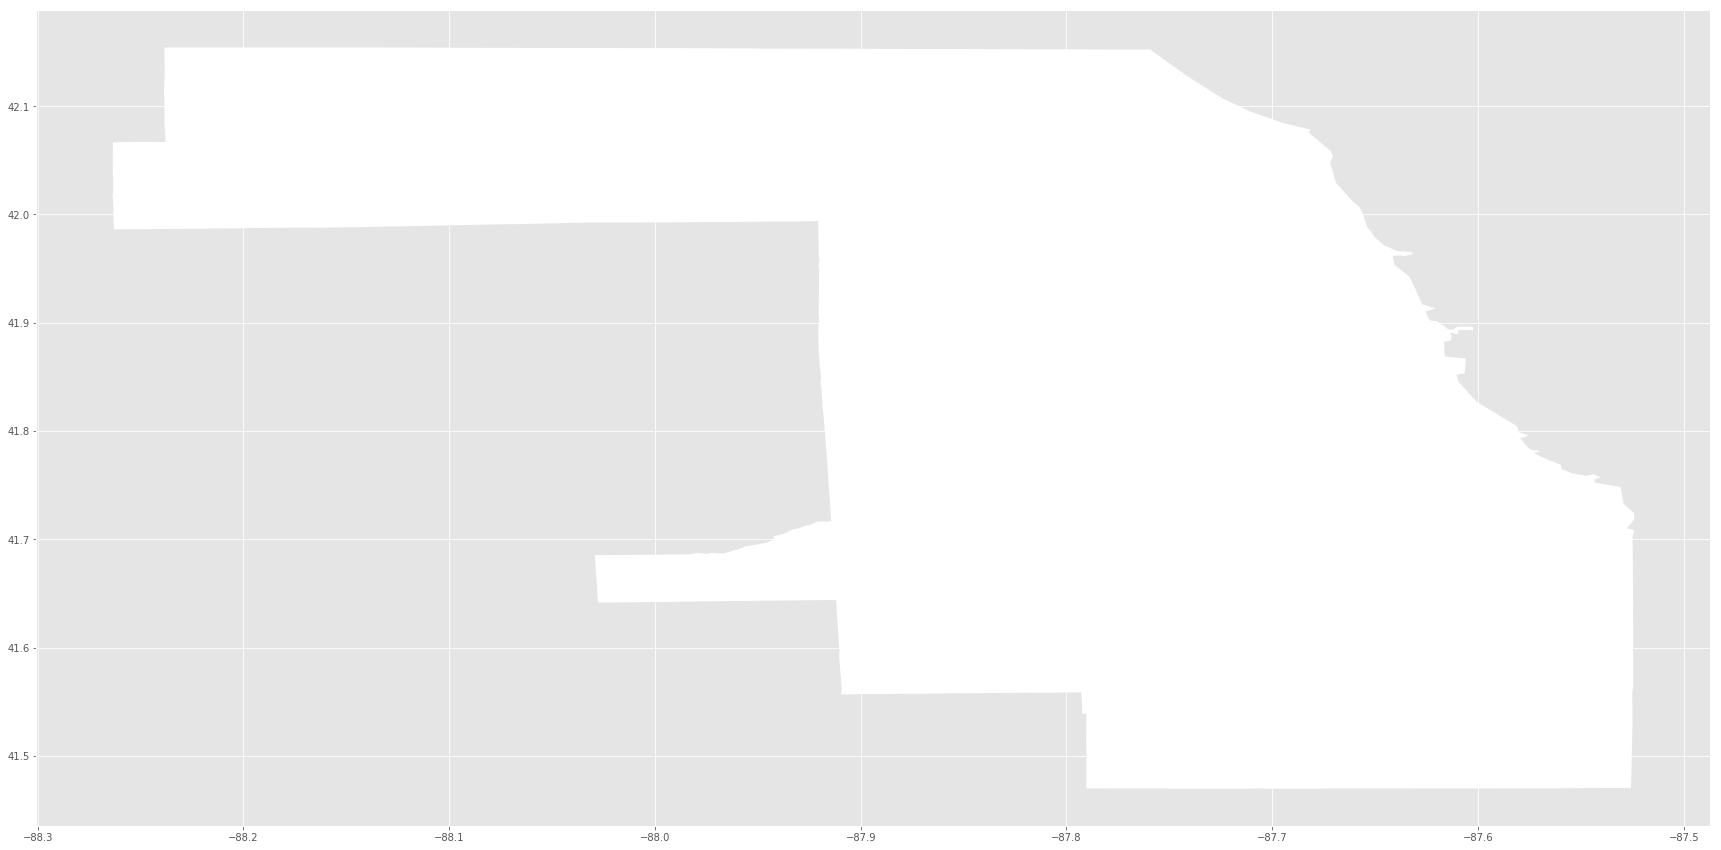

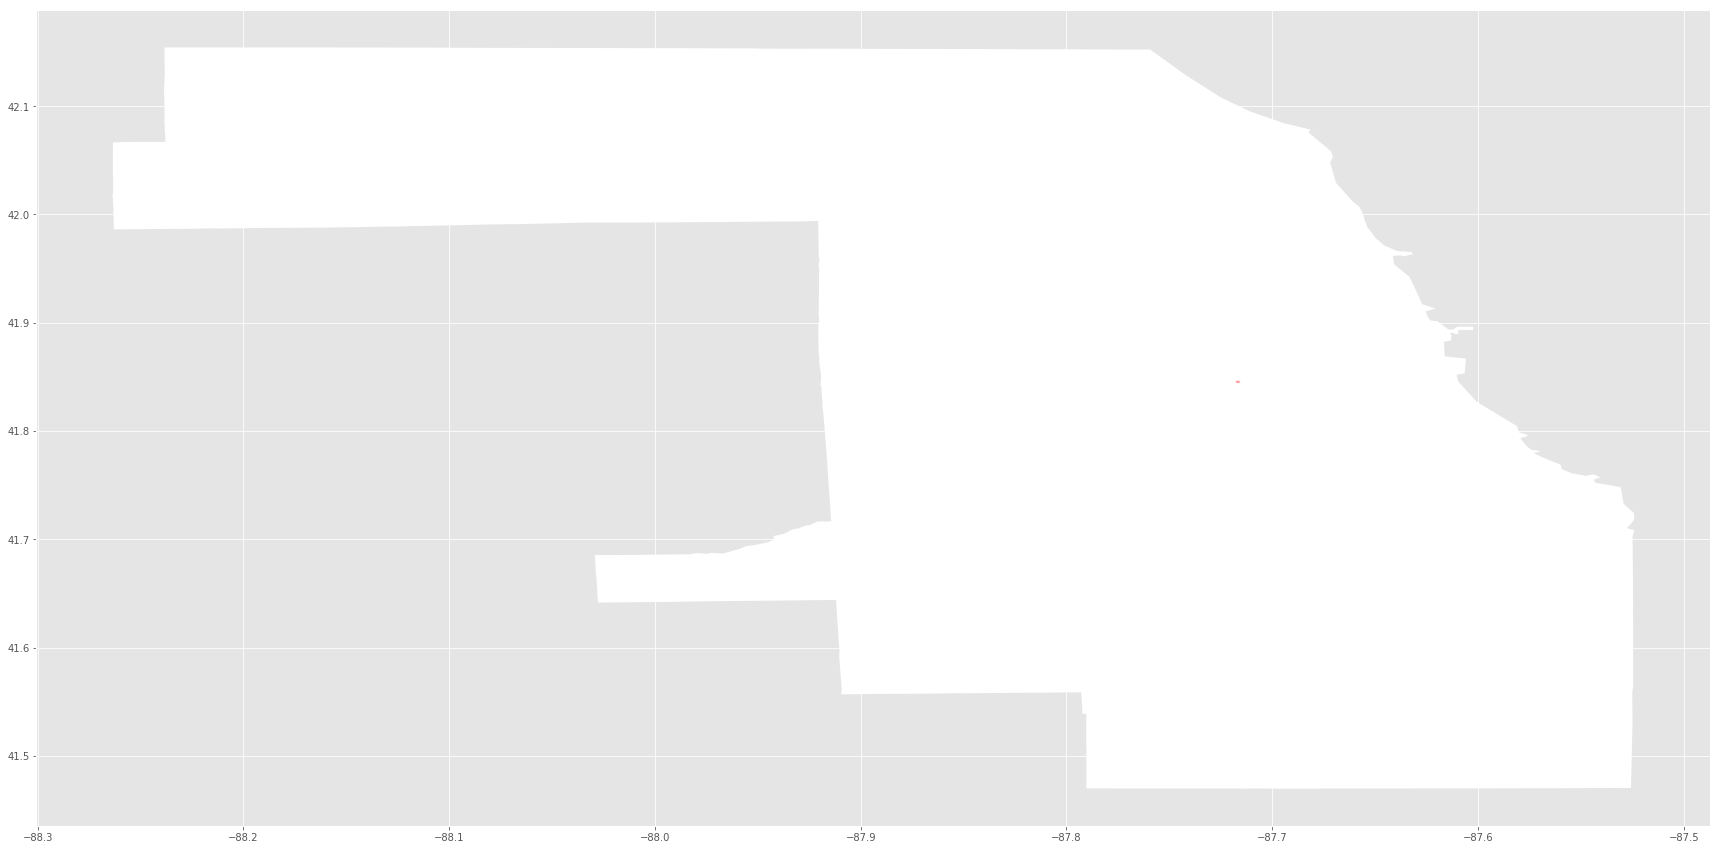

In [11]:
from plot import GeoPlot
# 'Circle', 'Large', 'Medium
obj_GP = GeoPlot()
obj_GP.set_figure(lenXaxis=30, lenYaxis=15)
obj_GP.base_plot(color='white', dataIN=cook_county)
obj_GP.add_plot(csvData, shapePlot=True)
obj_GP.show()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
366,17,031,01784766,0500000US17031,17031,cook,06,2447516257,1786450196,"POLYGON ((-88.263289 42.023056, -88.2632759999..."


In [6]:
np.unique(csvData['type'])

array(['', 'Circle', 'Large', 'Medium'], dtype=object)

In [ ]:
https://dev.virtualearth.net/REST/v1/Imagery/Metadata/Aerial/42.22353,-87.98569/19?mapSize=256,256&o=json&key=As1SMhbktDgHnBoak6XDezSKFHbgjCqLW4CAVx2s2601KLW_y6cM6vk5qb2C-wFA

In [7]:
https://dev.virtualearth.net/REST/v1/Imagery/Metadata/Aerial/42.22353,-87.98569/19?mapSize=256,256&o=json&he=1&key=As1SMhbktDgHnBoak6XDezSKFHbgjCqLW4CAVx2s2601KLW_y6cM6vk5qb2C-wFA

SyntaxError: invalid syntax (<ipython-input-7-45ddccc1457e>, line 1)

In [ ]:
{"authenticationResultCode":"ValidCredentials","brandLogoUri":"http:\/\/dev.virtualearth.net\/Branding\/logo_powered_by.png","copyright":"Copyright © 2018 Microsoft and its suppliers. All rights reserved. This API cannot be accessed and the content and any results may not be used, reproduced or transmitted in any manner without express written permission from Microsoft Corporation.","resourceSets":[{"estimatedTotal":1,"resources":[{"__type":"Location:http:\/\/schemas.microsoft.com\/search\/local\/ws\/rest\/v1","bbox":[42.2196672824293,-87.9926444572881,42.2273927175707,-87.9787355427119],"name":"920 N Lakeside Dr, Vernon Hills, IL 60061","point":{"type":"Point","coordinates":[42.22353,-87.98569]},"address":{"addressLine":"920 N Lakeside Dr","adminDistrict":"IL","adminDistrict2":"Lake County","countryRegion":"United States","formattedAddress":"920 N Lakeside Dr, Vernon Hills, IL 60061","locality":"Vernon Hills","postalCode":"60061"},"confidence":"High","entityType":"Address","geocodePoints":[{"type":"Point","coordinates":[42.22353,-87.98569],"calculationMethod":"Rooftop","usageTypes":["Display"]},{"type":"Point","coordinates":[42.2232396395457,-87.9847702060638],"calculationMethod":"Rooftop","usageTypes":["Route"]}],"matchCodes":["Good"]}]}],"statusCode":200,"statusDescription":"OK","traceId":"81a80798cbf14182ab9712c4f5f3cd50|CH1AECCD03|7.7.0.0|Ref A: 8651E50FCEBA4ACDA46F9DB0BBDBD207 Ref B: CH1EDGE1121 Ref C: 2018-02-23T02:54:46Z"}

In [ ]:
http://ecn.t3.tiles.virtualearth.net/tiles/a0302222123121112103.jpeg?g=6301

In [ ]:
http://ecn.t0.tiles.virtualearth.net/tiles/a0302222123003020030.jpeg?g=6301

In [ ]:
https://dev.virtualearth.net/REST/v1/Imagery/Metadata/Aerial/42.22353,-87.98569?mapSize=256,256&o=json&key=As1SMhbktDgHnBoak6XDezSKFHbgjCqLW4CAVx2s2601KLW_y6cM6vk5qb2C-wFA

In [ ]:
https://dev.virtualearth.net/REST/v1/Imagery/Metadata/CanvasDark/42.22353,-87.98569/16?mapSize=256,256&o=json&he=1&key=As1SMhbktDgHnBoak6XDezSKFHbgjCqLW4CAVx2s2601KLW_y6cM6vk5qb2C-wFA

In [ ]:
http://ak.dynamic.t3.tiles.virtualearth.net/comp/ch/0302222123121112?mkt=en-US&it=G,L&cstl=WD&og=238&n=z